In [1]:
import Pkg

Pkg.add("MLDataUtils")
Pkg.add("DelimitedFiles")
Pkg.add("Flux")
Pkg.add("DataFrames")
Pkg.add("LaTeXStrings")

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [2]:
using ImageCore
using MLDatasets
using LinearAlgebra
using DelimitedFiles
using Flux
using MLDataUtils
using Plots
using Printf
using Statistics
using DataFrames
using LaTeXStrings
using StatsBase

In [3]:
train_x, train_y = FashionMNIST.traindata()
test_x, test_y = FashionMNIST.testdata()

train_x = permutedims(train_x, [3, 2, 1])
test_x = permutedims(test_x, [3, 2, 1])

train_y = train_y .+ 1
test_y = test_y .+ 1

no_samples = size(train_x)[1]
no_labels = length(unique(train_y))[1];

In [4]:
# Given we are working with an MLP, we will flatten the vectors

train_x = [[train_x[i, :, :]...] for i in 1:no_samples]
test_x = [[test_x[i, :, :]...] for i in 1:size(test_x)[1]];

In [5]:
FashionMNIST.convert2image(FashionMNIST.traintensor(1))

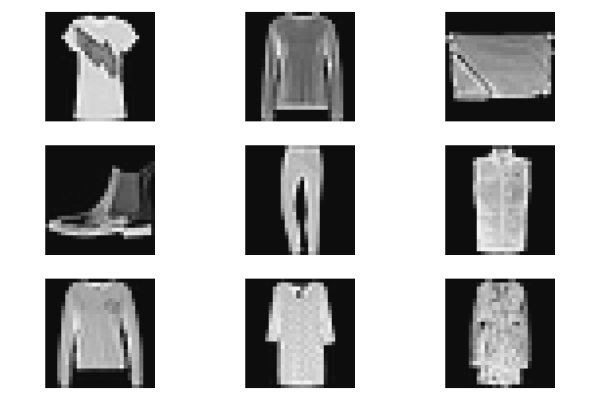

In [6]:
random_samples = rand(1:no_samples, 9);
plt = plot(layout = (3, 3), aspect_ratio = :equal, axis = false)

for (i, sample) in enumerate(random_samples)
    heatmap!(plt, 
        reshape(train_x[sample], 28, 28), 
        subplot = i, 
        yflip = true, 
        color = :grays, 
        colorbar = false, 
        axis = nothing)
end

display(plt)

In [7]:
function train_test_split(indices, shuffle, split)
    index_list = shuffle == 1 ? shuffleobs(indices) : deepcopy(indices)
    return splitobs(index_list, at = split)
end

train_idx, val_idx = train_test_split(1:no_samples, 1, 0.8);

In [8]:
# We will start by considering a Three Layer MLP 

mutable struct ThreeLayerPerceptron
    W1 ::Matrix{Float64}
    b1 ::Vector{Float64}
    W2 ::Matrix{Float64}
    b2 ::Vector{Float64}
    W3 ::Matrix{Float64}
    b3 ::Vector{Float64}
end

# Define a constructor

ThreeLayerPerceptron(no_hidden_nodes, no_features, no_classes) = ThreeLayerPerceptron(
    randn(no_hidden_nodes, no_features), 
    randn(no_hidden_nodes),
    randn(no_hidden_nodes, no_hidden_nodes),
    randn(no_hidden_nodes),
    randn(no_classes, no_hidden_nodes),
    randn(no_classes))

#Define the helper functions for this network

f(m::ThreeLayerPerceptron, x) = softmax(m.W3 * logistic.(m.W2 * logistic.(m.W1 * x + m.b1) + m.b2) + m.b3)
predict(m::ThreeLayerPerceptron, x) = findmax(f(m, x))[2];
loss(m::ThreeLayerPerceptron, x, y) = -log(f(m, x)[Int(y)])

loss (generic function with 1 method)

In [9]:
#Define helper functions for gradient calculations

function zero(m::ThreeLayerPerceptron)
    gradm = deepcopy(m)
    fill!(gradm.W1, 0)
    fill!(gradm.W2, 0)
    fill!(gradm.W3, 0)
    fill!(gradm.b1, 0)
    fill!(gradm.b2, 0)
    fill!(gradm.b3, 0)
    return gradm
end

function flatten(m::ThreeLayerPerceptron)
    toflatten = (m.W1, m.b1, m.W2, m.b2, m.W3, m.b3) 
    flatvec = vcat([x[:] for x in toflatten]...)
    return flatvec
end

function unflatten!(m::ThreeLayerPerceptron, vec)
    tounflatten = (m.W1, m.b1, m.W2, m.b2, m.W3, m.b3)
    offset = 1
    for parameter in tounflatten
        parameter[:] = vec[offset:offset + length(parameter) - 1]
        offset += length(parameter)
    end
    return m
end

function accuracy(m::ThreeLayerPerceptron, X, y)
    correct = 0
    no_samples = length(y)
    for i in 1:no_samples
        y_pred = predict(m, X[i])
        correct += y_pred == y[i]
    end
    acc = correct / no_samples
    return acc
end

logistic(x) = 1 / (1 + exp(-x))
logistic_prime(x) = logistic(x) * (1 - logistic(x))

outer(x, y) = x.*y'

function lossprime!(gradm, m, x, y)
    
    # Feed Forward
    
    a0 = x
    z1 = m.W1 * a0 + m.b1 
    a1 = logistic.(z1)
    z2 = m.W2 * a1 + m.b2 
    a2 = logistic.(z2)
    z3 = m.W3 * a2 + m.b3 
    a3 = softmax(z3)
    
    #backwards
    
    a3[Int(y)]  -= 1
    error_3 = a3
    error_2 = logistic_prime.(z2) .* m.W3' * error_3
    error_1 = logistic_prime.(z1) .* m.W2' * error_2
    
    gradm.b3 += error_3
    gradm.b2 += error_2
    gradm.b1 += error_1
    
    gradm.W3 += outer(error_3, a2)
    gradm.W2 += outer(error_2, a1)
    gradm.W1 += outer(error_1, a0)
        
end

function step!(m::ThreeLayerPerceptron, gradm::ThreeLayerPerceptron, lr, batch)
    vecm = flatten(m)
    vecgm = flatten(gradm)
    vecm .-= lr * vecgm / length(batch)
    unflatten!(m, vecm)
end    

batchify(indices, n) = shuffleobs([indices[i:min(i + n - 1, length(indices)), :] for i in 1:n:length(indices)])

batchify (generic function with 1 method)

In [ ]:
LEARNING_RATE = 0.05
BATCH_SIZE = 128
MAX_EPOCHS = 200
BEST_VAL_ACC = 0
BEST_MODEL = 0

loss_list = []
training_accuracies = []
val_accuracies = []

mlp = ThreeLayerPerceptron(128, 28*28, no_labels)

for epoch in 1:MAX_EPOCHS
    
    epoch_loss = 0
    batches = batchify(train_idx, BATCH_SIZE)
    
    Threads.@threads for batch in batches
        
        batch_loss = 0
        gradm = zero(mlp)
        
        for i in batch
            
            x_train = train_x[i]
            y_train = train_y[i]
            
            # Compute loss
            batch_loss += loss(mlp, x_train, y_train)
            
            # Calculate the gradient
            lossprime!(gradm, mlp, x_train, y_train)
        end
        
        epoch_loss += batch_loss
        
        # We take a step in the direction of the gradient

        step!(mlp, gradm, LEARNING_RATE, batch)
        
    end
    
    training_accuracy = accuracy(mlp, train_x[train_idx], train_y[train_idx])
    val_accuracy      = accuracy(mlp, train_x[val_idx], train_y[val_idx])

    @show epoch, training_accuracy, val_accuracy
    
    append!(training_accuracies, training_accuracy)
    append!(val_accuracies, val_accuracy)
    append!(loss_list, epoch_loss)
    
    if val_accuracy > BEST_VAL_ACC
        BEST_VAL_ACC = val_accuracy
        BEST_MODEL = deepcopy(mlp)
    end
    
    training_accuracy < 1.0 || break
    if epoch > 10 && (val_accuracies[end] - minimum(val_accuracies[end-(10-1):end-1]) < 0.001)
        println("Early Stopping Condition Met")
        break
    end
end


(epoch, training_accuracy, val_accuracy) = (1, 0.61425, 0.6138333333333333)
(epoch, training_accuracy, val_accuracy) = (2, 0.6765, 0.6791666666666667)
